<h1 style='color: darkcyan; font-size: 36px; font-weight: bold;'>WeatherPy Analysis</h1>

# <font color='teal' style='font-size: 20px;'>Conclusions:</font>
<hr style='border: 1.5px solid lightseagreen; background-color:#008b8b;'>
<ol style="line-height:33px; background-color:#008b8b; color:white; ">
  <li style="line-height:25px; text-align:justify; padding-top: 15px; padding-right: 15px;">On the graph Latitude vs Max Temperature, some cities have almost the same Latitude, but the variation in temperature between them can achieve 50<sup>o</sup> F. Most probably, that contradiction is justified by the difference of Longitude between them;</li>  
  <li style="line-height:25px; text-align:justify; padding-top: 15px; padding-right: 15px;">Considering the seasons of the year (summer, fall, winter, and spring) and the Earth's axis that is about 23.5<sup>o</sup>, we could say that as far from latitude 0<sup>o</sup> we are, as colder the temperature it will be;</li>    
  <li style="line-height:25px; text-align:justify; padding-top: 15px; padding-right: 15px;">As a whole, the highest wind speeds take place far from Latitude 0<sup>o</sup>;</li>  
  <li style="line-height:25px; text-align:justify; padding-top: 15px; padding-bottom: 15px; padding-right: 15px;">The variation of cloudiness percentage around the world is higher than the variation of humidity.</li>  
</ol>
<hr style='border: 1.5px solid lightseagreen;'>


In [1]:
# Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import requests as req
import os, json, csv, time, random, datetime 
from config import api_key
from citipy import citipy

In [2]:
# Assign the Cities' file to a variable 
cities_file = os.path.join(".", "Resources", "cities.csv")

### Create a list of cities utilizing citipy library

In [3]:
# Create lists with the complete latitudes and longitudes to better analysis accuracy. 
lat = [y for y in range (-88, 93, 4)]
lng = [x for x in range (-178, 188, 10)]

# Store the cities in a collection/set. This way we be sure we won't get any duplication.
collection = set()
# Line terminator to append to each city
lineterminator = '\r\n'
# Looping combining Latitudes and Longitudes to get cities 
for y in lat:
    for x in lng:
        # Get coordinates randomicaly from a small range. 
        rand_y = random.uniform( (y-2), (y+2) )
        rand_x = random.uniform( (x-2), (x+2) )
        # Get the nearest city of current coordinates
        city = citipy.nearest_city(rand_y,rand_x)
        collection.add(f"{city.city_name},{city.country_code}{lineterminator}")

# Preview total of cities 
print(f"Total of distinct cities: {len(collection)}")

Total of distinct cities: 672


In [4]:
# Save the selected cities in a csv file.
with open(cities_file, 'w') as writeFile:
    # Write the header
    writeFile.write(f"City,Country{lineterminator}")
    # Write the cities
    writeFile.writelines(collection)        

In [5]:
# Read the cities file
cities = pd.read_csv(cities_file, sep=',')  
# Convert the selected cities to a DataFrame
df_cities = pd.DataFrame(cities)
# Preview the DataFrame
df_cities.head()

,City,Country
0,parintins,br
1,san quintin,mx
2,araguaina,br
3,miandrivazo,mg
4,sanjwal,pk


In [6]:
# Create new fields for city.
df_cities["Cloudiness"] = None
df_cities["Date"] = None
df_cities["Humidity"] = 0
df_cities["Lat"] = 0.0
df_cities["Lng"] = 0.0
df_cities["Max Temp"] = 0.0
df_cities["Wind Speed"] = 0.0

# Set units to get the temperature in fahrenheit
units = "imperial"

# Set the default URL.
url = f"http://api.openweathermap.org/data/2.5/weather?APPID={api_key}&units={units}"

In [7]:
# Utilize Open Weather API to fill new fields. 
print("-----------------------------")
print("Beginning Data Retrieval")
print("-----------------------------")       

# Loop to execute requests for each city. 
count = 0 
for index, row in df_cities.iterrows(): 
    # Uncomment the two lines below to process just 20 cities. It will take more than 10 minutes to process all cities. 
#     if count == 20:
#         break
    count += 1
        
    # Add one second interval between requests to be in compliance with  Open Weather 
    # API guideline ("Free users can make 60 requests per minute").
    time.sleep(1) 

    # Build query URL for current city and print log.
    # Regarding we have cities with same name in different countries, we are appending 
    # country code to request the right city.
    city_country = f"{row['City']},{row['Country']}" 
    query_url = f"{url}&q={city_country}"
    print(f"Processing Record {count} - ({city_country.replace(',','/')})")
    print(query_url)
    
    try:
        # Run the request
        result = req.get(query_url).json()
        # Fill fields
        df_cities.loc[index, 'Cloudiness'] = result['clouds']['all']
        df_cities.loc[index, 'Date'] = datetime.datetime.fromtimestamp( int(result['dt']) ).strftime('%Y-%m-%d %H:%M:%S')
        df_cities.loc[index, 'Humidity'] = result['main']['humidity']
        df_cities.loc[index, 'Lat'] = result['coord']["lat"]
        df_cities.loc[index, 'Lng'] = result['coord']["lon"]
        df_cities.loc[index, 'Max Temp'] = result['main']['temp_max']
        df_cities.loc[index, 'Wind Speed'] = result['wind']['speed']
    except:    
        print(f"We've got an error when processing city={city_country} - {result}.")
        # Remove the city with error from DF.
        df_cities.drop([index],inplace=True)

print("-----------------------------")
print("Data Retrieval Complete")
print("-----------------------------")       
        
# Remove any City missing data
df_cities.dropna(how="any", inplace=True)  
# Reindex DF
df_cities.reset_index(drop=True, inplace=True)   


-----------------------------
Beginning Data Retrieval
-----------------------------
Processing Record 1 - (parintins/br)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=parintins,br
Processing Record 2 - (san quintin/mx)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=san quintin,mx
We've got an error when processing city=san quintin,mx - {'cod': '404', 'message': 'city not found'}.
Processing Record 3 - (araguaina/br)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=araguaina,br
Processing Record 4 - (miandrivazo/mg)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=miandrivazo,mg
Processing Record 5 - (sanjwal/pk)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=sanjwal,pk
Processing Record 6 - (chuy/uy)
http://api.o

Processing Record 51 - (hay river/ca)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=hay river,ca
Processing Record 52 - (jalu/ly)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=jalu,ly
Processing Record 53 - (kapaa/us)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=kapaa,us
Processing Record 54 - (oistins/bb)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=oistins,bb
Processing Record 55 - (tirumullaivasal/in)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=tirumullaivasal,in
Processing Record 56 - (inderborskiy/kz)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=inderborskiy,kz
We've got an error when processing city=inderborskiy,kz - {'cod': '404', 'messag

Processing Record 102 - (haines junction/ca)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=haines junction,ca
Processing Record 103 - (sao joao da barra/br)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=sao joao da barra,br
Processing Record 104 - (loubomo/cg)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=loubomo,cg
We've got an error when processing city=loubomo,cg - {'cod': '404', 'message': 'city not found'}.
Processing Record 105 - (dalmeny/ca)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=dalmeny,ca
Processing Record 106 - (brodokalmak/ru)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=brodokalmak,ru
Processing Record 107 - (saint-augustin/ca)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072a

Processing Record 152 - (kiruna/se)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=kiruna,se
Processing Record 153 - (pozo colorado/py)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=pozo colorado,py
Processing Record 154 - (copiapo/cl)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=copiapo,cl
Processing Record 155 - (udachnyy/ru)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=udachnyy,ru
Processing Record 156 - (bekessamson/hu)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=bekessamson,hu
Processing Record 157 - (sola/vu)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=sola,vu
Processing Record 158 - (calvinia/za)
http://api.openweathermap.org/data/2.5/wea

Processing Record 202 - (ko samui/th)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=ko samui,th
Processing Record 203 - (katsuura/jp)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=katsuura,jp
Processing Record 204 - (panzhihua/cn)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=panzhihua,cn
Processing Record 205 - (hithadhoo/mv)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=hithadhoo,mv
Processing Record 206 - (ancud/cl)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=ancud,cl
Processing Record 207 - (teshie/gh)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=teshie,gh
Processing Record 208 - (port alfred/za)
http://api.openweathermap.org/data/2.5/weather?

Processing Record 252 - (belz/ua)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=belz,ua
Processing Record 253 - (morehead/pg)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=morehead,pg
Processing Record 254 - (kharhial/in)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=kharhial,in
Processing Record 255 - (ewa beach/us)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=ewa beach,us
Processing Record 256 - (sosnovo-ozerskoye/ru)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=sosnovo-ozerskoye,ru
Processing Record 257 - (ribeira grande/pt)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=ribeira grande,pt
Processing Record 258 - (mendahara/id)
http://api.openweat

Processing Record 298 - (oyo/ng)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=oyo,ng
Processing Record 299 - (mecca/sa)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=mecca,sa
Processing Record 300 - (rafai/cf)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=rafai,cf
Processing Record 301 - (neenah/us)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=neenah,us
Processing Record 302 - (pregradnaya/ru)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=pregradnaya,ru
Processing Record 303 - (cayenne/gf)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=cayenne,gf
Processing Record 304 - (morant bay/jm)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e3

Processing Record 348 - (hualmay/pe)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=hualmay,pe
Processing Record 349 - (rusne/lt)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=rusne,lt
Processing Record 350 - (pevek/ru)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=pevek,ru
Processing Record 351 - (port macquarie/au)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=port macquarie,au
Processing Record 352 - (jardim/br)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=jardim,br
Processing Record 353 - (ozgon/kg)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=ozgon,kg
We've got an error when processing city=ozgon,kg - {'cod': '404', 'message': 'city not found'}

Processing Record 397 - (lubango/ao)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=lubango,ao
Processing Record 398 - (mitu/co)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=mitu,co
Processing Record 399 - (bethel/us)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=bethel,us
Processing Record 400 - (cobourg/ca)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=cobourg,ca
Processing Record 401 - (nanortalik/gl)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=nanortalik,gl
Processing Record 402 - (sur/om)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=sur,om
Processing Record 403 - (yingcheng/cn)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e33

Processing Record 446 - (ketchikan/us)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=ketchikan,us
Processing Record 447 - (rabat/ma)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=rabat,ma
Processing Record 448 - (berlevag/no)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=berlevag,no
Processing Record 449 - (margate/za)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=margate,za
Processing Record 450 - (tashla/ru)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=tashla,ru
Processing Record 451 - (sorong/id)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=sorong,id
Processing Record 452 - (samusu/ws)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad

Processing Record 495 - (dzhusaly/kz)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=dzhusaly,kz
We've got an error when processing city=dzhusaly,kz - {'cod': '404', 'message': 'city not found'}.
Processing Record 496 - (escondido/us)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=escondido,us
Processing Record 497 - (portobelo/pa)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=portobelo,pa
Processing Record 498 - (rungata/ki)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=rungata,ki
We've got an error when processing city=rungata,ki - {'cod': '404', 'message': 'city not found'}.
Processing Record 499 - (riberalta/bo)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=riberalta,bo
Processing Record 500 - (peleduy/r

Processing Record 542 - (tabou/ci)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=tabou,ci
Processing Record 543 - (rawannawi/ki)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=rawannawi,ki
We've got an error when processing city=rawannawi,ki - {'cod': '404', 'message': 'city not found'}.
Processing Record 544 - (broken hill/au)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=broken hill,au
Processing Record 545 - (sibu/my)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=sibu,my
Processing Record 546 - (pasni/pk)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=pasni,pk
Processing Record 547 - (trelew/ar)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=trelew,a

Processing Record 592 - (sept-iles/ca)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=sept-iles,ca
Processing Record 593 - (bonavista/ca)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=bonavista,ca
Processing Record 594 - (fort-shevchenko/kz)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=fort-shevchenko,kz
Processing Record 595 - (ushuaia/ar)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=ushuaia,ar
Processing Record 596 - (trat/th)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=trat,th
Processing Record 597 - (yafran/ly)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=yafran,ly
Processing Record 598 - (tumannyy/ru)
http://api.openweathermap.org/data/2.5/w

Processing Record 640 - (san luis/ar)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=san luis,ar
Processing Record 641 - (aswan/eg)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=aswan,eg
Processing Record 642 - (abu jubayhah/sd)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=abu jubayhah,sd
We've got an error when processing city=abu jubayhah,sd - {'cod': '404', 'message': 'city not found'}.
Processing Record 643 - (westport/nz)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=westport,nz
Processing Record 644 - (nemuro/jp)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=imperial&q=nemuro,jp
Processing Record 645 - (norman wells/ca)
http://api.openweathermap.org/data/2.5/weather?APPID=f5072ad53e338012bcc90c7b09683864&units=

In [8]:
# Preview total cities remaining after requests.
print(f"Total cities remaining: {len(df_cities)}")

# Preview new fields filled
df_cities.head()

Total cities remaining: 575


,City,Country,Cloudiness,Date,Humidity,Lat,Lng,Max Temp,Wind Speed
0,parintins,br,100,2019-07-07 19:03:19,89,-2.63,-56.73,75.74,0.47
1,araguaina,br,62,2019-07-07 19:03:21,75,-7.19,-48.21,76.21,4.85
2,miandrivazo,mg,0,2019-07-07 19:03:23,88,-19.53,45.46,62.47,1.32
3,sanjwal,pk,20,2019-07-07 19:03:24,66,33.76,72.43,87.01,9.17
4,chuy,uy,71,2019-07-07 19:03:25,72,-33.69,-53.46,43.28,5.37


In [9]:
df_cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575 entries, 0 to 574
Data columns (total 9 columns):
City          575 non-null object
Country       575 non-null object
Cloudiness    575 non-null int64
Date          575 non-null object
Humidity      575 non-null int64
Lat           575 non-null float64
Lng           575 non-null float64
Max Temp      575 non-null float64
Wind Speed    575 non-null float64
dtypes: float64(4), int64(2), object(3)
memory usage: 40.5+ KB


In [10]:
# Get the analysis date. It will be used on title graphs.
analisys_date = df_cities.loc[0:0]["Date"][0]
# Get just the date, cut hour, min, and sec out. 
analisys_date = analisys_date[0:10]
# Format date and convert to String
dt = datetime.datetime.strptime(analisys_date, '%Y-%m-%d')
analisys_date = dt.strftime("%B %d, %Y")

In [11]:
# Set graphs stile  
plt.style.use('fivethirtyeight')

# Create a function to set graphs
def set_graph(y_axis, y_lim, title, y_label, image_file_name):
    # Start graph
    fig, ax = plt.subplots(figsize=(9,6))
    fig.set_facecolor('w')

    # Set commom params for all graphs
    x_axis = df_cities["Lat"].tolist()    
    x_lim = [-80, 100]
    x_label = "Latitude"
    
    # Set x and y limits
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    # Set the title
    ax.set_title(f"{title} ({analisys_date})", alpha=0.9, fontsize=15)

    # Set labels
    ax.set_xlabel(x_label, alpha=0.8, fontsize=14)
    ax.set_ylabel(y_label, alpha=0.8, fontsize=14)

    # Set stick
    ax.tick_params(direction='out', length=0, width=2, grid_color='w', labelsize='small', grid_linewidth=1.2)
    ax.scatter(x_axis, y_axis, marker="o",color="blue",edgecolors='black', s=40, alpha=0.8)
    
    # Save the graph image
    plt.savefig(image_file_name)

### Latitude vs Max Temperature Plot

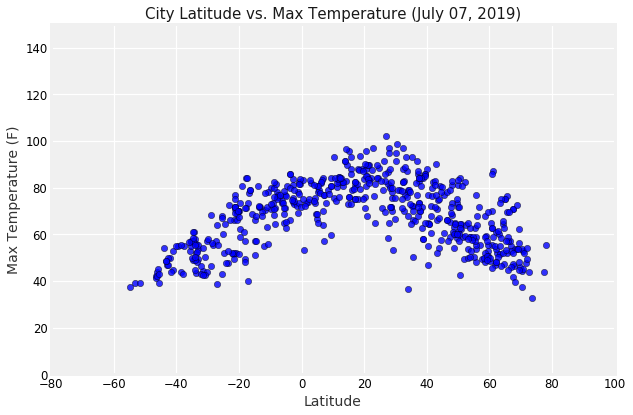

In [12]:
# Set the graph
set_graph(df_cities["Max Temp"].tolist(),     # y_axis
          [0, 150],                           # ylim   
          "City Latitude vs. Max Temperature",# Title
          "Max Temperature (F)",              # yLabel
          "Latitude_vs_MaxTemperature.png")   # image_file_name

# Show the Figure
plt.show()

### Latitude vs. Humidity Plot

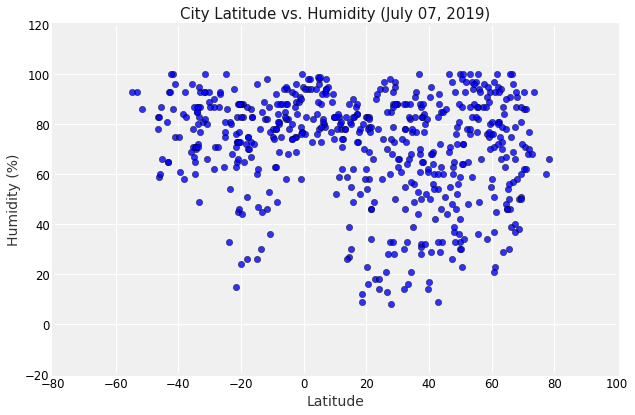

In [13]:
# Set graph
set_graph(df_cities["Humidity"].tolist(), # y_axis
          [-20, 120],                     # ylim   
          "City Latitude vs. Humidity",   # Title
          "Humidity (%)",                 # yLabel
          "Latitude_vs_Humidity.png")     # image_file_name

# Show the Figure
plt.show()

### Latitude vs. Cloudiness Plot

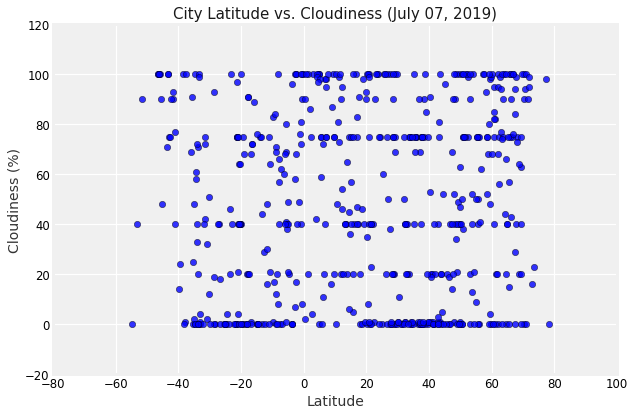

In [14]:
# Set graph
set_graph(df_cities["Cloudiness"].tolist(),# y_axis
          [-20, 120],                      # ylim   
          "City Latitude vs. Cloudiness",  # Title
          "Cloudiness (%)",                # yLabel
          "CityLatitude_vs_Cloudiness.png")# image_file_name

# Show the Figure
plt.show()


### Latitude vs. Wind Speed Plot

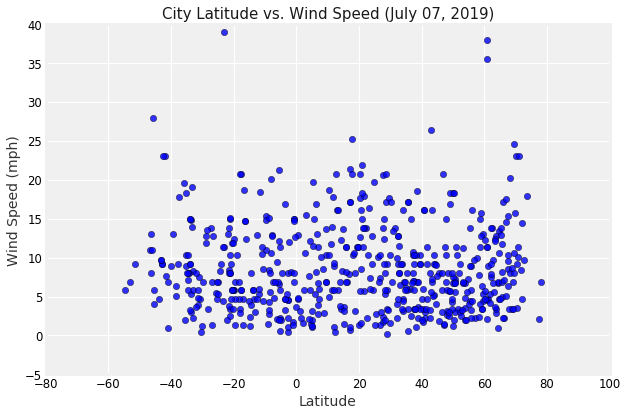

In [15]:
# Set graph
set_graph(df_cities["Wind Speed"].tolist(),# y_axis
          [-5, 40],                        # ylim   
          "City Latitude vs. Wind Speed",  # Title
          "Wind Speed (mph)",              # yLabel
          "Latitude_vs_WindSpeed.png")     # image_file_name

# Show the Figure
plt.show()

In [16]:
# Save Cities Data.
df_cities.to_csv(cities_file, encoding="utf-8", index=False)